# **LAB 2: Optimizing Generative AI Workloads on ARM Server Processors**

## Introduction

Welcome to the second lab in our series on **Optimizing Generative AI Workloads with ARM Processors**! In this hands-on session, you will build on the concepts learned in Lab 1 by learning how to vectorize AI workloads for efficiently with the powerful intrinsics of ARM Neoverse Processors. These include:

- **NEON** (for SIMD acceleration)
- **DotProd** (dot product extension)
- **I8MM** (integer matrix multiplication)
- **SVE** (Scalable Vector Extension)

We will learn about and utilize these intrinsics through the **KleidiAI library**, which provides optimized microkernels for matrix multiplication, the main workload of AI applications. You will also benchmark these kernels utilizing these different intrinsics to see their performance differences and compare the results to a benchmark library called **BLAS** which is the standard library for linear algebra routines. Beyond benchmarking, you will also integrate these optimized kernels into PyTorch to enable **quantized matrix multiplication**, and deploy your own highly optimized small language model with **4-bit** quantization. 

---

### **Lab Objectives**

1. **Explore Advanced ARM Intrinsics**  
   Gain a deeper understanding of CPU intrinsics and learn how the specific intrinsics provided by Arm Neoverse, including **DotProd**, **I8MM**, and **SVE**, enhance performance. Explore how these intrinsics,     available in modern ARM architectures, are utilized to accelerate matrix multiplication operations.

2. **Learn the KleidiAI Library**  
   Discover how KleidiAI implements these intrinsics in microkernels and why it can outperform traditional approaches in certain use cases.

3. **Benchmark KleidiAI Against BLAS**  
   Implement and benchmark KleidiAI microkernels using different intrinsics against the **BLAS** library to quantify performance benefits.

4. **Quantize Matrix Multiplication in PyTorch**  
   Integrate the KleidiAI kernels into PyTorch to perform quantized matrix multiplications, comparing performance and accuracy trade-offs.

5. **Implement and Evaluate 4-Bit Quantization**  
   Apply **groupwise int4 quantization** to the **OpenELM-7B** model, measuring **latency** and **memory** improvements on an ARM Neoverse Server.

---
### **Prerequisites**

- **Basic Knowledge of Linux**: Comfortable working in a Linux terminal.
- **C/C++ and Python Programming**: Familiarity with writing and compiling code.
- **Matrix Multiplication**: Understanding of linear algebra basics.
- **Completion of Lab 1 (Recommended)**: Familiarity with NEON vector instructions and quantization concepts.

---
**By the end of this lab**, you will have hands-on experience combining low-level ARM intrinsics, specialized libraries, and quantization techniques to push the performance of large language models on ARM server processors. These skills will enable you to optimize generative AI workloads in both **resource-constrained** and **server-class** ARM environments.


# 1. Explore Advanced ARM Intrinsics 
Before we dive into the ARM intrinsic features of Neoverse processors, let's start by preparing example inputs for a matrix multiplication. To make this example relevant to a real neural network, we'll identify and extract the largest matrix multiplication operation used by the OpenELM Large Language Model. This can be done by running the following cells. The first cell downloads the model from Hugging Face, and the second uses a feature of pytorch called model hooks to extract and example activation matrix and the relavant weight matrix. 


In [1]:
import torch 
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", trust_remote_code=True) # download the tokenizer
model = AutoModelForCausalLM.from_pretrained("apple/OpenELM-270M-Instruct", trust_remote_code=True) # download the model (this may take a while)



tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

configuration_openelm.py:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/apple/OpenELM-270M-Instruct:
- configuration_openelm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_openelm.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/apple/OpenELM-270M-Instruct:
- modeling_openelm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

### Collect largest weight matmul in LLM 
The output of the cell below should show you the dimensions of the matrix multiplication inputs. As you can see they are very large and given a matrix multiplication has 'O(sequence_length x input_channels x output_channels)' you can see why perofming this operation could be so important for AI inference. 

In [2]:
import torch
import torch.nn.functional as F
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
activations = {} # Initialize to store the activations

prompt = "Arm is a company that"  # create a sample prompt for the llm 
inputs = tokenizer(prompt, return_tensors="pt") # tokenize the prompt ready for inputting into the model

# Define a hook function to capture output activation of each matrix multiplication
def get_activation_input(name):
    def hook(model, input, output):
        # 'input' is a tuple; we take the first element for the input tensor
        activations[name] = output[0]
    return hook


# the largest matmul is after the last normalization, We therefor apply the hook 
# on this layer to the the input for th last matmul which is the projection from 
# tokens to probabilities over the all possible tokens in the vocabulary.
layer = model.transformer.norm
hook_handle = layer.register_forward_hook(get_activation_input('token_activations'))

# Run the model forward pass
with torch.no_grad():
    model(**inputs)

# Extract the projection weight matrix and the input activation tensor from the hook
W = model.transformer.token_embeddings.weight.data.clone()
X = activations['token_activations']

hook_handle.remove()
print(f"The collected weight matrix has shape {W.shape[0]}x{W.shape[1]} (output_channels x input_channels)")
print(f"The collected activation tensor has shape {X.shape[0]}x{X.shape[1]} (sequence_length x input_channels)")

The collected weight matrix has shape 32000x1280 (output_channels x input_channels)
The collected activation tensor has shape 6x1280 (sequence_length x input_channels)


# Explanation

We have two key tensors:

1. **Activation Tensor `X`**: Shape \([6, 1280]\)  
   - This corresponds to 6 tokens in the input sequence, each represented by a 1280-dimensional embedding generated by the OpenElm transformer.

2. **Weight Matrix**: Shape \([32000, 1280]\)  
   - There are 32,000 possible tokens in the model’s vocabulary, and each token is associated with a 1280-dimensional parameter vector.

When we multiply these two tensors, their common dimension of 1280 aligns, producing an output of shape \([6, 32000]\). The first dimension corresponds to the 6 tokens in the sequence, and the second dimension corresponds to the 32,000 tokens in the vocabulary.

The resulting matrix provides the logits for every token in the vocabulary for each position in the sequence. These logits can then be used to generate probability distributions over the next predicted token.


Now that we have saved the inputs to the matrix multiplication, lets measure torch's matrix multiplication latency from python. We can use that as a reference to compare against when using the arm intrinsics for further acceleration. 

### Benchmark torch latency for the matmul

In [3]:
import time

def measure_time():
    start = time.perf_counter()
    with torch.no_grad():
        y = torch.mm(X, W.T) # perform the matrix multiplication 
    end = time.perf_counter()
    return (end - start) * 1_000_000  # Convert to microseconds

# Run multiple times and average
times = [measure_time() for _ in range(100)]
torch_latency_us = sum(times) / len(times)
print(f"{torch_latency_us:.2f} µs")

7180.43 µs


Your output should be something order of 7000 microseconds. That is pretty good, but I thik we can do better by utilizing the intrinsics that Neoverse provides. Lets dive into some low-level with c++ to gain grater control and insight as to how the hardware is working. We however still want to use the same matrix multiply inputs as above so lets write them out to disk so our c++ programs can read the same example. 

In [4]:
!mkdir src/cpp/assets/

X.numpy().tofile("src/cpp/assets/x_fp32.bin") # write the activation tensor to disk 
W.numpy().tofile("src/cpp/assets/w_fp32.bin") # write the weight tensor to disk

## Naive Matmul Operator
We can again also write the naive implementation of the matrix multiplication in c++ without any parallelization, memory optimizations or vectorization. This is just like in the first lab except that the matrix multiplication is involving non-square matrices, and hence we have to pass the multiplication dimensions 'M, K and N' which are integer values, defining the shape of the matrix multilication (read the code cell comments for more details). Note again that we again store the matrices as a flat pointer, representing the matrices as a single vector in row-major order. (Go back to lab-1 to learn about row-major if you are unsure)

In [26]:
%%writefile src/cpp/naive/kernel.cpp

#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void matrix_multiply_naive(float* A, float* B, float* C, int M, int K, int N) {
    // # M: the number of rows in the left hand matric (M = A.shape[0])
    // # K: the inner dimensions of the multiple (K == A.shape[1] == B.shape[0])
    // # N: the number of columns in the right hand matrix (N == B.shape[1])
    for (int i = 0; i < M; i++) {
        for (int j = 0; j < N; j++) {
            C[i * N + j] = 0;
            for (int k = 0; k < K; k++) {
                C[i * N + j] += A[i * K + k] * B[k * N + j];
            }
        }
    }
}

Overwriting src/cpp/naive/kernel.cpp


### Benchmark the Naive Operator

We have written some benchmark code inside 'src/cpp/naive/benchmark_naive.cpp' that will measure the kernels latency. You can build, compile and run it using the cell below

In [27]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define the build directory path
build_dir = "src/cpp/naive/build"

# Create the build directory if it doesn't exist
os.makedirs(build_dir, exist_ok=True)

# Configure the project with CMake
subprocess.run(["cmake", ".."], cwd=build_dir, check=True)

# Build the project using Make
subprocess.run(["make"], cwd=build_dir, check=True)
print(" ")
print("======> Benchmarking Naive Kernel <========")
# Execute the benchmark binary
subprocess.run(["./benchmark_naive"], cwd=build_dir)
print("=========> Benchmark completed. <========== \n")


-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/naive/build
[ 33%] Building CXX object CMakeFiles/benchmark_naive.dir/benchmark_naive.cpp.o
[ 66%] Building CXX object CMakeFiles/benchmark_naive.dir/kernel.cpp.o
[100%] Linking CXX executable benchmark_naive
[100%] Built target benchmark_naive
 
======> Benchmarking Naive Kernel <========
Time taken: 1.18941e+06 microseconds
=========> Benchmark completed. <========== 



The naive kernel achieves a latency of approximately 1000 microseconds, making it roughly 7 times faster than PyTorch in Python. This performance gain is primarily due to the lower overhead of C++ implementations compared to Python. While PyTorch employs highly optimized binary kernels internally, the Python interface introduces additional latency through dynamic type checking, interpreter overhead, and function call dispatch. In contrast, C++ provides direct, low-level control over memory and computation, minimizing such overhead.

As a result, using the PyTorch Python example for comparison with this naive C++ implementation is not ideal. A more appropriate comparison would be with the KleidiAI library, a highly efficient matrix multiplication library written in C++ and Assembly specifically optimized for ARM devices. KleidiAI leverages advanced techniques such as MicroKernels and ARM intrinsic features to accelerate computation.

Let us start by cloning the KleidiAI library.

# Clone KleidiAI

In [28]:
!git clone https://git.gitlab.arm.com/kleidi/kleidiai.git

fatal: destination path 'kleidiai' already exists and is not an empty directory.


## Understanding the KleidiAI Micro-Kernel

The KleidiAI micro-kernel, available from the KleidiAI library is a minimal, highly optimized piece of code designed to accelerate a specific machine learning operations on ARM CPUs. Unlike typical kernels or functions, micro-kernels are crafted to provide flexibility in how they process data, allowing them to handle portions of an output tensor rather than requiring the entire operation to be completed in one step. This flexibility enables efficient parallelization across multiple threads and improves performance by tailoring the computation to different hardware architectures and output tile sizes. For instance, you can partition a single matrix multiplication into multiple blocks of computation, and pass each of these blocks to a KleidiAI micro-kernels accross different processing cores, thereby increasing throughput. 

Micro-kernels are available in different variants, each optimized for specific ARM architectures, technologies, and computational parameters. Despite these variations, all micro-kernel variants of the same type perform the same operation and produce identical results, ensuring consistency across different hardware and configurations. We will next go through variations of KleidiAI micro-kernels, learn about their naming conventions and the technologies they use to accelerate our matrix multiplcation example. First up, is the NEON SIMD processing concept that we learn't about in Lab1 for the floating point 32 precision. 

## Creating a Kleidi Kernel

The KleidiAI micro-kernels are located in the kleidiai/kai/ukernels directory. These variants follow a specific naming convention:

`kai_matmul_<fused_ops>_<dst_info>_<lhs_info>_<rhs_info>_<mr x nr x kacc>_<technology>_<feature>_<instruction>`

In this convention, `fused_ops` specifies additional operations integrated with the matrix multiplication. For example, `clamp` represents an operation that clamps the input activations to ensure numerical stability.
`dst_info` defines the output data type. `lhs_info` provides information about the input data type, referring to where the activation tensor is supplied. `rhs_info` specifies the data type of the weights.
You can refer to the repository documentation for a detailed explanation of the naming conventions used for data types. For now, we will explore several examples and explain their components step by step, starting with the floating point 32 matrix muliplication. 

# FP32 NEON MLA

In [29]:
%%writefile src/cpp/f32_f32_f32p/kernel.cpp

#include <arm_neon.h>

#include "kai_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla.h"
#include "kai_matmul_clamp_f32_f32_f32p_interface.h"


constexpr kai_matmul_clamp_f32_f32_f32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_n_step_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_nr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_kr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_sr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_lhs_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_rhs_packed_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_dst_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_dst_size_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_run_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla};

Overwriting src/cpp/f32_f32_f32p/kernel.cpp


The above cell defines a KleidiAI micro-kernel with the following struct name:

`kai_matmul_clamp_f32_f32_f32p_ukernel`

In this kernel, `f32` is specified as both `lhs_info` and `dst_info`, meaning it operates on 32-bit floating point precision for both the input activation tensor and the output data. The right-hand side (`rhs_info`) is also `f32`, but with a `p` suffix, indicating that the right-hand input (the weight matrix) must be packed in a specific format.

Packing the weight matrix is a key optimization used by KleidiAI. It aligns the data in memory to enhance memory locality, ensuring more efficient memory access patterns and increasing cache efficiency. By leveraging techniques such as tiling, loop unrolling, NEON SIMD vectorization, and packed weight matrices, the micro-kernel achieves fast access patterns, minimizes memory latency, and maximizes computational throughput. These optimizations collectively lead to a significant reduction in overall latency compared to a naive implementation. Lets test it and see what improvements we get. 

### Build and Benchmark the 32-bit Floating Point Kernel 

In [51]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define the build directory path
build_dir = "src/cpp/f32_f32_f32p/build"

# Create the build directory if it doesn't exist
os.makedirs(build_dir, exist_ok=True)

# Configure the project with CMake
subprocess.run(["cmake", ".."], cwd=build_dir, check=True)

# Build the project using Make
subprocess.run(["make"], cwd=build_dir, check=True)

print(" ")
print("=====> Benchmarking KleidiAI FP32 Kernel <========")
# Execute the benchmark binary
subprocess.run(["./benchmark_f32"], cwd=build_dir)
print("===========> Benchmark completed. <=============== \n")

-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
[ 33%] Built target benchmark_f32
[ 66%] Built target benchmark_f32_scaling
[100%] Built target kai_f32_inf
 
=====> Benchmarking KleidiAI FP32 Kernel <========
Time taken: 11540 microseconds
===========> Benchmark completed. <=============== 



The result should be in the range of tens of microseconds, which is impressive. By using the KleidiAI kernels, we achieve a **1000x improvement in latency** compared to the naive kernel, and this is without applying any quantization. To better understand how this performance is achieved, we can use a tool called **process watch** to examine the intrinsics used by the operator. Please follow the instructions below carefully. There are four steps:

**Step 1:**  
Run the first code cell below. This will execute the matrix multiplication in an infinite loop, ensuring that the process does not terminate. The output will include a **Process ID (PID)**, which we will use to analyze the computation.

**Step 2:**  
Copy the **PID** from the first cell and paste it into the second cell after the `-p` flag. This will configure the process watch tool to monitor the running matrix multiplication process and display its analysis in real time.

**Step 3:**  
Once the analysis has been printed a few times, interrupt the kernel to stop the output. To do this, go to the top-left menu in JupyterLab, click on **Kernel**, and select **Interrupt Kernel**.

**Step 4:**  
Finally, run the third code cell to terminate the matrix multiplication process.


Lets use a tool called process watch to check what kernels are being run?

In [52]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f32_f32_f32p/build/kai_f32_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 20665


In [53]:
!sudo ./processwatch/processwatch -p 20665 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              71.38    0.00     0.00     0.00     0.00     100.00   23240   
20665    kai_f32_inf      71.38    0.00     0.00     0.00     0.00     100.00   23240   
^C


In [54]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

The analysis should show roughly 70% of the instructions are using the NEON SIMD registers, and hence making very effective use of parallelization to acheive this vectorization. Next we can implement the exact smae kernel with the KleidiAI library using the cell below but utilizing fp16 precision not fp32. This saves half the memory bandwidth. 

# FP16 NEON MLA 

Next up is the floating point 16 kernel. This uses the floating point 16 precision with just 16 bits as opposed to fp32 that uses 32. Use half the memory per element reduces the load on memory bandwidth as less data needs to be read and written to DRAM. 

In [55]:
%%writefile src/cpp/f16_f16_f16p/kernel.cpp

#include <arm_neon.h>

#include "kai_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla.h"
#include "kai_matmul_clamp_f16_f16_f16p_interface.h"

constexpr kai_matmul_clamp_f16_f16_f16p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_n_step_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_nr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_kr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_sr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_lhs_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_rhs_packed_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_dst_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_dst_size_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_run_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla};

Overwriting src/cpp/f16_f16_f16p/kernel.cpp


### Build and Benchmark the 16-bit Floating Point Kernel 

In [56]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define the build directory path
build_dir = "src/cpp/f16_f16_f16p/build"

# Create the build directory if it doesn't exist
os.makedirs(build_dir, exist_ok=True)

# Configure the project with CMake
subprocess.run(["cmake", ".."], cwd=build_dir, check=True)

# Build the project using Make
subprocess.run(["make"], cwd=build_dir, check=True)

print(" ")
print("=====> Benchmarking KleidiAI FP16 Kernel <========")
# Execute the benchmark binary
subprocess.run(["./benchmark_f16"], cwd=build_dir)
print("===========> Benchmark completed. <=============== \n")


-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
[  6%] Building CXX object CMakeFiles/benchmark_f16.dir/benchmark_f16.cpp.o
[ 13%] Building CXX object CMakeFiles/benchmark_f16.dir/kernel.cpp.o
[ 20%] Linking CXX executable benchmark_f16
[ 33%] Built target benchmark_f16
[ 40%] Building CXX object CMakeFiles/benchmark_f16_scaling.dir/benchmark_f16_scaling.cpp.o
[ 46%] Building CXX object CMakeFiles/benchmark_f16_scaling.dir/kernel.cpp.o
[ 53%] Linking CXX executable benchmark_f16_scaling
[ 66%] Built target benchmark_f16_scaling
[ 73%] Building CXX object CMakeFiles/kai_f16_inf.dir/kai_f16_inf.cpp.o
[ 80%] Building CXX object CMakeFiles/kai_f16_inf.dir/kernel.cpp.o
[ 86%] Linking CXX executable kai_f16_inf
[100%] Built target kai_f16_inf
 
=====> Benchmarking KleidiAI FP16 Kernel <========
Time taken: 5925 microseconds
===========> Benchmark completed. <=============== 



Your benchmark for the FP16 kernel should aroung the 6000 microseconds mark, representing an improvement over the previous FP32 kernel. This performance gain is achievable due to the Neoverse architecture’s native support for FP16 data types. Additionally, since FP16 precision uses only half the number of bits compared to FP32, the memory bandwidth requirement for reading and writing from main memory is significantly reduced. This reduction not only lowers the bandwidth load but also enhances cache utilization, improving the cache hit rate and further reducing latency.

Let now analalysis the computational workload using **processwatch**. Please follow the same 4 steps that were taken for the f32 kernel. 

In [57]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f16_f16_f16p/build/kai_f16_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 20764


In [58]:
!sudo ./processwatch/processwatch -p 20764 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              83.97    0.00     0.00     0.00     0.00     100.00   23227   
20764    kai_f16_inf      83.97    0.00     0.00     0.00     0.00     100.00   23227   
^C


In [59]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

The process watch should indicate an increase in the percentage of NEON instructions utilized conpared to floating point 32. This is because FP16 operations reduce memory bandwidth requirements when reading and writing half-precision activations and weights compared to full precision. Consequently, the CPU can devote more cycles to computation rather than being stalled by memory access, resulting in higher overall computational efficiency. Now lets move on to learn about some of the key featurs of ARM Neoverse Architectures that can be used to further accelerate AI workloads

## DotProd

The next extension we will introdce is the **DotProd**. The dotprod extension uses dot product instructions, and offers a powerful way to perform multiply-accumulate operations on vectors, which can be used to multipily rows and columns of the weight and activation matrices for a full matrix multiplication. There are two types of these instructions:

- **SDOT**: Signed Dot Product
- **UDOT**: Unsigned Dot Product

### How They Work

These instructions operate on **32-bit elements** packed inside larger vectors (either 64-bit, 128-bit NEON vectors, or scalable vectors in SVE2). Within each 32-bit element, there are four **8-bit sub-elements**. The dot product process follows these steps:

1. **Multiply**: Each 8-bit element in a 32-bit segment of the first vector is multiplied by the corresponding 8-bit element in the second vector.
2. **Accumulate Products**: The four resulting products within each 32-bit segment are summed together to create a new 32-bit value.
3. **Add to Destination**: This 32-bit sum is then added to the corresponding 32-bit element in the destination vector.

This effectively computes an inner, dot, or scalar product for each set of four 8-bit pairs, updating the destination vector elements as follows:

c0 = c0 + ( (a0 * b0) + (a1 * b1) + (a2 * b2) + (a3 * b3) )

### Performance Benefits

The dot product instructions are designed to maximize parallel computation:

- Processors like **Arm Cortex-X2** and **Arm Neoverse V1** can execute **four dot product instructions in parallel**.
- This parallelism allows them to handle **four 128-bit operations per cycle**.
- Each 128-bit operation contains four groups of four 8-bit multiplies and accumulates, resulting in a total of **64 multiply and accumulate operations per cycle**.


Lets see it in action, first however we need to define the KleidiAI microkernel that uses the dotprod insturctions. 

In [75]:
%%writefile src/cpp/f32_i8_i4_dotprod/kernel.cpp

#include <arm_neon.h>
#include <string>

#include "kai_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod.h"
#include "kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_interface.h"


constexpr kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_n_step_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_mr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_nr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_kr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_sr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_lhs_packed_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_rhs_packed_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_dst_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_dst_size_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_run_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod};

Overwriting src/cpp/f32_i8_i4_dotprod/kernel.cpp


The naming convention for this kernel may seem complex at first, but let's break it down step by step:

### Destination Information (`dst_info`)
- **`dst_info`**: This part is similar to the previous format using `f32`, indicating that the output of the matrix multiplication is a 32-bit tensor.

### Left-Hand Side Information (`lhs_info`)
- **`lhs_info`**: The identifier `qsi8d32p` carries detailed information about the left-hand side tensor:
  - **`q`**: Indicates that the tensor is quantized.
  - **`s`**: Specifies that the quantization is symmetric.
  - **`i8`**: The quantized data type is 8-bit integer (`int8`).
  - **`d32`**: Signifies per-dimension quantization, meaning there is one scalar quantization parameter for each dimension.
  - **`p`**: Indicates that the matrix must be **packed** for efficient processing.

### Right-Hand Side Information (`rhs_info`)
- **`rhs_info`**: The identifier `qsi4c32p` describes the right-hand side tensor:
  - **`q`**: Indicates that the tensor is quantized.
  - **`s`**: Specifies that the quantization is symmetric.
  - **`i4`**: The quantized data type is 4-bit integer (`int4`).
  - **`c32`**: Means per-group quantization, with a single scale parameter for every 32 elements in the tensor.
  - **`p`**: Indicates that the matrix must be **packed**.

### Build and Run 

In [76]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define the build directory path
build_dir = "src/cpp/f32_i8_i4_dotprod/build"

# Create the build directory if it doesn't exist
os.makedirs(build_dir, exist_ok=True)

# Configure the project with CMake
subprocess.run(["cmake", ".."], cwd=build_dir, check=True)

# Build the project using Make
subprocess.run(["make"], cwd=build_dir, check=True)

print(" ")
print("=====> Benchmarking KleidiAI Int8 DotProd Kernel <========")
# Execute the benchmark binary
subprocess.run(["./benchmark_dotprod"], cwd=build_dir)
print("=================> Benchmark completed. <================= \n")

-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
[  5%] Building CXX object CMakeFiles/benchmark_dotprod.dir/benchmark_i8_dotprod.cpp.o
[ 11%] Building CXX object CMakeFiles/benchmark_dotprod.dir/kernel.cpp.o
[ 16%] Linking CXX executable benchmark_dotprod
[ 33%] Built target benchmark_dotprod
[ 38%] Building CXX object CMakeFiles/benchmark_dotprod_scaling.dir/benchmark_i8_dotprod_scaling.cpp.o
[ 44%] Building CXX object CMakeFiles/benchmark_dotprod_scaling.dir/kernel.cpp.o
[ 50%] Linking CXX executable benchmark_dotprod_scaling
[ 66%] Built target benchmark_dotprod_scaling
[ 72%] Building CXX object CMakeFiles/kai_i8_dotprod_inf.dir/kai_i8_dotprod_inf.cpp.o
[ 77%] Building CXX object CMakeFiles/kai_i8_dotprod_inf.dir/kernel.cpp.o
[ 83%] Linking CXX executable kai_i8_dotprod_inf
[100%] Built target kai_i8_dotprod_inf
 
=====> Benchmarking KleidiAI Int8 DotProd Kernel <========
Tim

In [77]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f32_i8_i4_dotprod/build/kai_i8_dotprod_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 21313


In [78]:
!sudo ./processwatch/processwatch -p 20865 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 

Failed to initialize perf sampling: No such process
Failed to open perf event.


In [79]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

Process watch should show you in the DotProd column that roughly 5 percent of the instructions utilize the dot product extension, indicating the kernel is sucessfully utilizing the acceleration extension. 

## i8mm Extension

The next extension we will use is called **i8mm**. It uses the **SMMLA** instruction that is part of the i8mm extension for ARM, designed to efficiently perform matrix multiply-accumulate operations on 8-bit integer data-types. Specifically, it handles small matrix multiplications on vectors by working with 2×8 and 8×2 matrices of signed 8-bit integers, yielding a 2×2 matrix of 32-bit results which are then accumulated into a destination register.

### How SMMLA Works

This vector instruction takes two source vectors, each containing 16 signed 8-bit elements, and treats them as small matrices:
- The first source vector is viewed as a 2×8 matrix.
- The second source vector is considered an 8×2 matrix.

The operation proceeds as follows:

1. **Matrix Multiplication**: It multiplies the two matrices together. Given the dimensions, this results in a 2×2 matrix of 32-bit integer products.
2. **Accumulate Results**: Each element of the resulting 2×2 matrix is then added to the corresponding element in a 2×2 matrix located in the destination vector.

Because it effectively performs eight parallel dot-product computations for each output element, SMMLA can calculate eight multiply-accumulate operations simultaneously.

### Performance Characteristics

SMMLA is optimized to deliver high throughput. Its design goal is to match or surpass the combined throughput of two SDOT instructions in a scalar context by performing more operations in parallel. For architectures implementing SMMLA, this means:

- High efficiency in performing multiple multiply-accumulate operations simultaneously, ideal for matrix computations and dot products.

In summary, SMMLA leverages the i8mm extension to accelerate small matrix multiplications by combining multiple 8-bit multiply and accumulate operations in a single instruction, making it a powerful tool for high-performance computing tasks on ARM processors.

In [80]:
%%writefile src/cpp/f32_i8_i4_i8mm/kernel.cpp

#include <arm_neon.h>
#include "kai_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm.h"
#include "kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_interface.h"


constexpr kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_n_step_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_mr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_nr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_kr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_sr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_lhs_packed_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_rhs_packed_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_dst_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_dst_size_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_run_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm};



Overwriting src/cpp/f32_i8_i4_i8mm/kernel.cpp


### Build and Run 

In [81]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define the build directory path
build_dir = "src/cpp/f32_i8_i4_i8mm/build"

# Create the build directory if it doesn't exist
os.makedirs(build_dir, exist_ok=True)

# Configure the project with CMake
subprocess.run(["cmake", ".."], cwd=build_dir, check=True)

# Build the project using Make
subprocess.run(["make"], cwd=build_dir, check=True)

print(" ")
print("=====> Benchmarking KleidiAI Int8 I8MM Kernel <========")
# Execute the benchmark binary
subprocess.run(["./benchmark_i8_i8mm"], cwd=build_dir)
print("===========> Benchmark completed. <=============== \n")


-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_i8mm/build
[  5%] Building CXX object CMakeFiles/benchmark_i8_i8mm.dir/benchmark_i8_i8mm.cpp.o
[ 11%] Building CXX object CMakeFiles/benchmark_i8_i8mm.dir/kernel.cpp.o
[ 16%] Linking CXX executable benchmark_i8_i8mm
[ 33%] Built target benchmark_i8_i8mm
[ 38%] Building CXX object CMakeFiles/benchmark_i8_i8mm_scaling.dir/benchmark_i8_i8mm_scaling.cpp.o
[ 44%] Building CXX object CMakeFiles/benchmark_i8_i8mm_scaling.dir/kernel.cpp.o
[ 50%] Linking CXX executable benchmark_i8_i8mm_scaling
[ 66%] Built target benchmark_i8_i8mm_scaling
[ 72%] Building CXX object CMakeFiles/kai_i8_i8mm_inf.dir/kai_i8_i8mm_inf.cpp.o
[ 77%] Building CXX object CMakeFiles/kai_i8_i8mm_inf.dir/kernel.cpp.o
[ 83%] Linking CXX executable kai_i8_i8mm_inf
[100%] Built target kai_i8_i8mm_inf
 
=====> Benchmarking KleidiAI Int8 I8MM Kernel <========
Time taken: 8030 microseconds


In [82]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f32_i8_i4_i8mm/build/kai_i8_i8mm_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")


Main process ID: 21392


In [83]:
!sudo ./processwatch/processwatch -p 20961 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 

Failed to initialize perf sampling: No such process
Failed to open perf event.


In [84]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

### Plot Latency Scaling 

Now we have successfully utilized the hardware extensions available on **Arm Neoverse** processors, lets benchmark them against eachother across different matrix sizes. As a baseline we will also include the **OpenBLAS** Library. This is the open standard for implementing highly optimized matrix multiplications and is used as the conventional backend for pytorch on CPU devices. 

Lets first write out some matrix sizes to measure the matrix multiplication latency using the next cell.

In [95]:
%%writefile src/cpp/common/sizes.cpp

int sizes[] = {32, 64, 128, 256, 512, 1024, 2048, 4096};

Overwriting src/cpp/common/sizes.cpp


### Build and Benchmark Scalability

In [96]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define projects with their build directories and benchmark executables
projects = {
    "src/cpp/f32_f32_f32p/build": "benchmark_f32_scaling",
    "src/cpp/f16_f16_f16p/build": "benchmark_f16_scaling",
    "src/cpp/f32_i8_i4_dotprod/build": "benchmark_dotprod_scaling",
    "src/cpp/f32_i8_i4_i8mm/build": "benchmark_i8_i8mm_scaling",
    "src/cpp/blas/build": "blas_scaling_benchmark"
}

for build_dir, benchmark in projects.items():
    os.makedirs(build_dir, exist_ok=True)
    print(f"Building in {build_dir}...")
    subprocess.run(["cmake", ".."], cwd=build_dir, check=True)
    subprocess.run(["make"], cwd=build_dir, check=True)
    print(f"Running {benchmark}...")
    subprocess.run([f"./{benchmark}"], cwd=build_dir, check=True)


Building in src/cpp/f32_f32_f32p/build...
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
[ 33%] Built target benchmark_f32
[ 40%] Building CXX object CMakeFiles/benchmark_f32_scaling.dir/benchmark_f32_scaling.cpp.o
[ 46%] Linking CXX executable benchmark_f32_scaling
[ 66%] Built target benchmark_f32_scaling
[100%] Built target kai_f32_inf
Running benchmark_f32_scaling...
Building in src/cpp/f16_f16_f16p/build...
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
[ 33%] Built target benchmark_f16
[ 40%] Building CXX object CMakeFiles/benchmark_f16_scaling.dir/benchmark_f16_scaling.cpp.o
[ 46%] Linking CXX executable benchmark_f16_scaling
[ 66%] Built target benchmark_f16_scaling
[100%] Built target kai_f16_inf
Running benchmark_f16_scaling...
Building in src/cpp/f32_i8_i4_dotprod/build.

Run the scaling benchmarks 

## Plot the scaling results

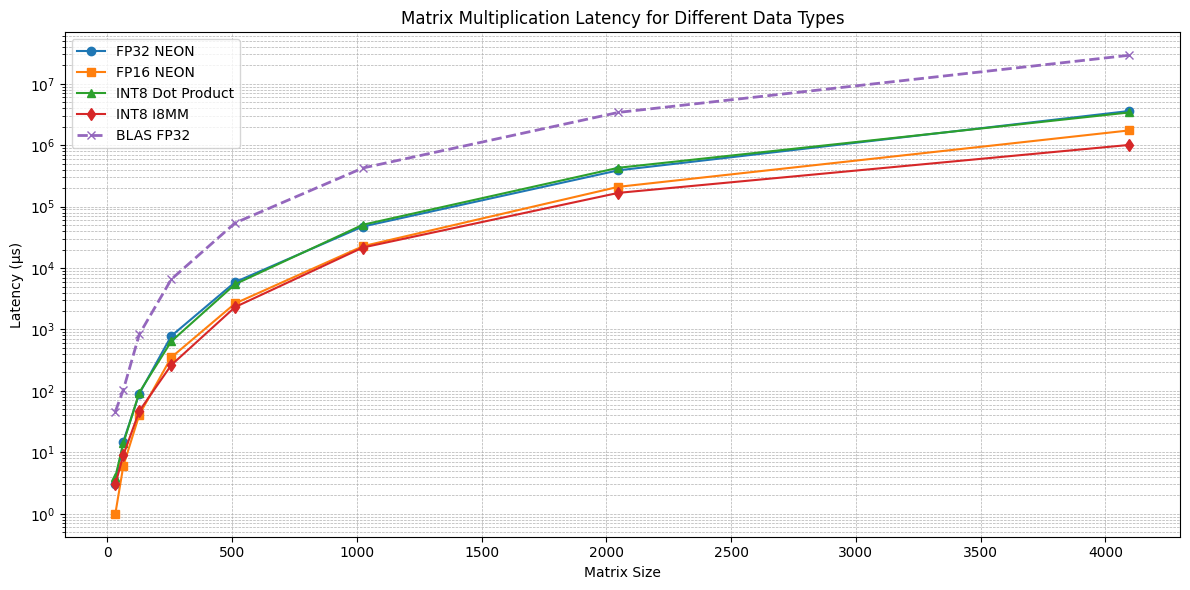

In [97]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 

# Load datasets
f32_data = pd.read_csv("src/cpp/results/f32_scaling_results.csv")
f16_data = pd.read_csv("src/cpp/results/f16_scaling_results.csv")
int8_dotprod_data = pd.read_csv("src/cpp/results/i8_dotprod_scaling_results.csv")
int8_i8mm_data = pd.read_csv("src/cpp/results/i8_i8mm_scaling_results.csv")
blas_data = pd.read_csv("src/cpp/results/blas_f32_scaling_results.csv")

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot each dataset
plt.plot(f32_data['Size'], f32_data['Latency(us)'], label="FP32 NEON", marker='o')
plt.plot(f16_data['Size'], f16_data['Latency(us)'], label="FP16 NEON", marker='s')
plt.plot(int8_dotprod_data['Size'], int8_dotprod_data['Latency(us)'], label="INT8 Dot Product", marker='^')
plt.plot(int8_i8mm_data['Size'], int8_i8mm_data['Latency(us)'], label="INT8 I8MM", marker='d')
plt.plot(blas_data['Size'], blas_data['Latency(us)'], label="BLAS FP32", marker='x', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel("Matrix Size")
plt.ylabel("Latency (µs)")
plt.title("Matrix Multiplication Latency for Different Data Types")
plt.yscale('log')  # Use log scale for latency if the values span multiple orders of magnitude
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()



From the scaling graph, the x-axis represents the matrix size, while the y-axis shows the matrix multiplication latency measured in microseconds. The graph clearly indicates that all implementations of KleidiAI matrix multiplications outperform the BLAS library. This suggests that, to optimize inference on ARM CPUs, it is highly beneficial to use the KleidiAI library as the backend for linear algebra operations.

Among the implementations, the int8 matrix multiplication (i8mm extension) is the fastest. This performance advantage is intuitive because the SMMLA instructions execute multiple dot products in parallel, leveraging the hardware capabilities efficiently. The next best performer is the floating-point 16-bit kernel, which utilizes NEON vectors and SIMD processing to accelerate computations.

**Let's now use KleidiAI as a backend to optimize the inference of the OpenELM Large Language Model.**


---
# Onto KleidiAI Integrations with torch. Lets start by using the 4bit weight only kernel

In [98]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torchao.quantization.utils import prepare_int4_weight_and_scales_and_zeros
from torchao.utils import find_multiple

### Set some matmul hyperparameters 

In [99]:
out_features = 256 # number of output channels of the matrix multiplication 
in_features = 128 # number of input channels of the matrix multiplication 
groupsize = 32 # number of weights per scale parameter
inner_k_tiles = 8 # inner parameter for cache optimization

### Create the floating point matrices 

In [100]:
weight = torch.randn(out_features, in_features, dtype=torch.float32)
x = torch.randn(1, in_features, dtype=torch.float32)

## use torchao to perform the group quantization 

In [101]:
w_int4x8, scales_and_zeros = prepare_int4_weight_and_scales_and_zeros(
    weight, 
    groupsize, 
    inner_k_tiles, 
    "symmetric_groupwise", 
    precision=torch.float32,
)

### Look at the shapes to see what has been done 

In [102]:
print(f"Full Precision weights: shape {weight.shape} dtype {weight.dtype}")
print(f"Prepared weights: shape {w_int4x8.shape} dtype {w_int4x8.dtype}")
print(" ")
print("weight number equality: ", w_int4x8.numel(), "==", weight.numel()//2 + (weight.numel()//groupsize * 2))

Full Precision weights: shape torch.Size([256, 128]) dtype torch.float32
Prepared weights: shape torch.Size([1024, 18]) dtype torch.uint8
 
weight number equality:  18432 == 18432


**Explanation of the Prepared Weights Size**

We can see above that the following equality between the number of weights in the prepared quantized weights (w-int4x8) and the original weights (weight) is true. 

```python
w_int4x8.numel() == (weight.numel() // 2) + (weight.numel() // groupsize * 2) 
```

***NOTE: weight.numel() gives the number of elements inside a pytorch tensor***

This can be explained by our use of 4-bit quantization in which we need to pack the quantized weights in addition to it's scale parameters into the w_int4x8 tensor. To do so, this can be interpreted in two parts:

1. **Half the number of weights**:  
   - Because each original weight is mapped to a 4-bit number, and two 4-bit values fit in a single byte, we only need half as many bytes as the total number of full-precision weights.  
   - This is expressed by `(weight.numel() // 2)` in the weight number equality.

2. **Storage for scale parameters**:  
   - Each group of weights has a corresponding scale factor, and the number of groups is `(weight.numel() // groupsize)`.  
   - These scale factors are stored in `float16` format, which requires 2 bytes for each scale, leading to `* 2`.  
   - Hence, the term `(weight.numel() // groupsize * 2)` accounts for the total bytes needed for all scale factors.

Therefore, when you add these two parts:

```python
(weight.numel() // 2) + (weight.numel() // groupsize * 2) 
```

you get the total storage (in bytes) for the quantized weights plus the scale parameters. This total matches the number of elements in `w_int4x8`, ensuring the shape `torch.Size([1024, 18])` correctly reflects both packed 4-bit weights and their scale factors.


**Explanation of the Prepared Weights shape**

In [103]:
w_int4x8.shape

torch.Size([1024, 18])

The weight preparation function has performed group quantization, quantizing each group to a single row in the matrix. This gives `weight.numel()s//group_size` rows. We can check that it is true using the below line 

In [104]:
weight.numel() // groupsize

1024

ok so that means that there is one group per row, each one with their own scale parameter. Given that the groupsize we have used is 32, and when using 4-bit quantization we can pack 2 elemtns into a single byte, that gives a row size of 16 bytes. This leaves a discrepancy of 2 bytes. This 2 byte difference is used to hold the symmetric scale parameter in float16 format. Therefore the row size of w_int4x8 is: 

In [105]:
groupsize // 2 + 2

18

# Lets now use the kleidiai kernel that has been integrated into torch 
after performing the quantization, we must pack the weight into a shape required by the kleidiai kernels. This, is a memory optimization step. 

In [106]:
weight_int4pack = torch.ops.aten._kai_weight_pack_int4(w_int4x8, scales_and_zeros.float(), out_features, in_features, groupsize)

# define a forward function to use the kleidi int4 kernel 

In [107]:
def linear_forward_int4_symmetric_groupwise(x, weight_int4pack, out_features, in_features):
    origin_x_size = x.size()
    c = torch.ops.aten._kai_input_quant_mm_int4(x, weight_int4pack, x.shape[-2],out_features, in_features, 32)
    new_shape = origin_x_size[:-1] + (out_features,)
    c = c.reshape(new_shape)
    return c


In [108]:
out_kai = linear_forward_int4_symmetric_groupwise(x, weight_int4pack, out_features, in_features)

# Lets have a look at the quantization Error

In [109]:
out_baseline = torch.matmul(x, weight.T) # compute the baseline operation
print(out_kai.flatten()[:5])
print(out_baseline.flatten()[:5])
error = (out_baseline - out_kai).abs() / out_baseline.abs()

tensor([ 8.7778, 12.4034, -8.0793, -5.4258, -3.2346])
tensor([ 8.8780, 12.1892, -7.0240, -4.5940, -3.5516])


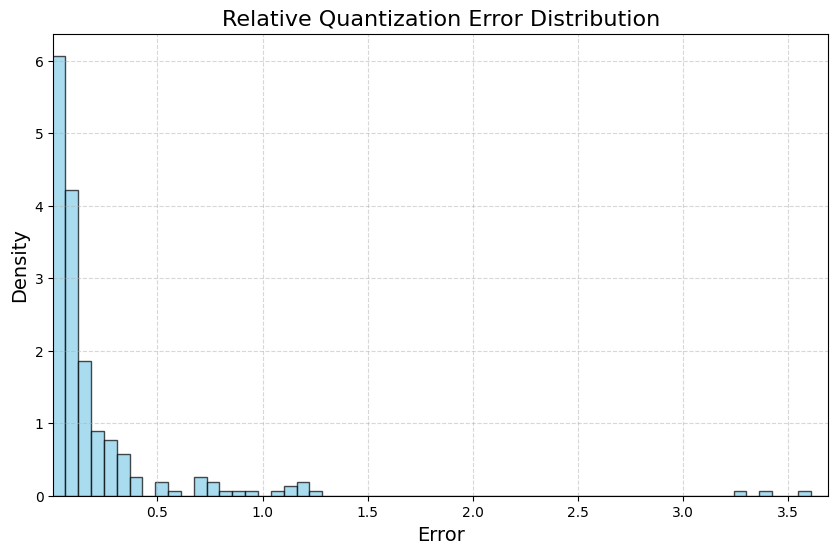

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'error' is your data tensor
data = error.flatten().numpy()

plt.figure(figsize=(10, 6))

# Plot the histogram with fewer bins and density normalization
plt.hist(data, bins=100, color='skyblue', edgecolor='black', alpha=0.7, density=True)

# Add titles and labels
plt.title('Relative Quantization Error Distribution', fontsize=16)
plt.xlabel('Error', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Optionally, set x-axis limits to exclude extreme outliers
# For example, between the 1st and 99th percentiles
lower, upper = np.percentile(data, [1, 99])
plt.xlim(lower, upper)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

## Quantizing A model with KleidiAI
define a 4-bit weight only linear using kleidiai kernel

In [20]:
class Int4WeightOnlyKAILinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True): 
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.register_buffer(
            "weight",
            torch.zeros((torch.ops.aten.get_kai_weight_pack_int4_size(out_features,in_features,groupsize)), dtype=torch.uint8)
        )

        self.register_buffer(
            "scales_and_zeros",
            torch.zeros((0), dtype=torch.float32)
        )

        if bias is not False: 
            self.register_buffer(
                "bias",
                torch.zeros((self.out_features), dtype=torch.float32)
            )
        else: 
            self.register_buffer("bias", None)

    def forward(self, x):
        out = linear_forward_int4_symmetric_groupwise(x, self.weight, self.out_features, self.in_features)
        if self.bias is not None:
            out += self.bias 
        return out

define function to return quantized version of layer

In [21]:
def quantize_linear_layer(layer):
    fp_weight = layer.weight.data.detach()
    out_features = layer.out_features
    in_features = layer.in_features

    w_int4x8, scales_and_zeros = prepare_int4_weight_and_scales_and_zeros(
        fp_weight, 
        groupsize=32, # groupsize
        inner_k_tiles=8, # inner_k_tiles 
        scheme="symmetric_groupwise", 
        precision=torch.float32
    )

    weight_int4pack = torch.ops.aten._kai_weight_pack_int4(
        w_int4x8, 
        scales_and_zeros.float(), 
        out_features, 
        in_features, 
        groupsize
    )

    use_bias = layer.bias is not None
    layer4bit = Int4WeightOnlyKAILinear(in_features, out_features, use_bias)

    layer4bit.weight = weight_int4pack
    layer4bit.scales_and_zeros = scales_and_zeros
    if use_bias:
        layer4bit.bias.data.copy_(layer.bias.data)

    return layer4bit


define function to quantize an entire nn.Module inplace

In [22]:
def quantize_model(model):
    for name, child in model.named_children():
        if isinstance(child, nn.Linear):
            # Quantize the linear layer
            quantized_layer = quantize_linear_layer(child)
            setattr(model, name, quantized_layer)
        else:
            # Recursively apply to child modules
            quantize_model(child)
    return model


create the model

In [70]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer


model = AutoModelForCausalLM.from_pretrained("apple/OpenELM-270M-Instruct", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", trust_remote_code=True)

prompt = "Arm is a company that" 
inputs = tokenizer(prompt, return_tensors="pt")

Lets sample a generation from the model

In [71]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

generated_ids = model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=20)
generated_text_fp = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
generated_text_fp

'Arm is a company that has been in the business of manufacturing and supplying various types of'

before quantizing get full precision memory consumption

In [72]:
import torch

baseline_memory_consumption = 0  # Memory in bytes
for name, param in model.named_parameters():  # Use model.named_parameters() to iterate over model parameters
    baseline_memory_consumption += param.numel() * param.element_size()

# Convert to megabytes (MB)
baseline_memory_consumption_mb = baseline_memory_consumption / (1024 ** 2)

print(f"Baseline memory consumption: {baseline_memory_consumption_mb:.2f} MB")

Baseline memory consumption: 1035.79 MB


before quantizing get the full precision generation latency 

In [73]:
import time
    
baseline_latency = 0
for _ in range(10):
    st = time.time()
    model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=20)
    et = time.time()
    baseline_latency += (et - st) * 1000
baseline_latency /= 10

print(f"Time taken: {baseline_latency:.2f} ms")

Time taken: 434.65 ms


qauntize the model 

In [74]:
quantize_model(model.transformer)

OpenELMModel(
  (token_embeddings): Embedding(32000, 1280)
  (layers): ModuleList(
    (0-4): 5 x OpenELMDecoderLayer(
      (attn): OpenELMMultiHeadCausalAttention(
        query_heads=12, key_heads=3, value_heads=3
        (qkv_proj): Int4WeightOnlyKAILinear()
        (pos_embedding): OpenELMRotaryEmbedding(	model_dim=64, max_seq_length=4096, freq_constant=10000)
        (q_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
        (k_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
        (out_proj): Int4WeightOnlyKAILinear()
      )
      (ffn): OpenELMFeedForwardNetwork(
        (ffn_with_glu) : True
        (proj_1): Int4WeightOnlyKAILinear()
        (proj_2): Int4WeightOnlyKAILinear()
        (act): SiLU()
      )
      (ffn_norm): OpenELMRMSNorm(num_features=1280, eps=1e-06)
      (attn_norm): OpenELMRMSNorm(num_features=1280, eps=1e-06)
    )
    (5-11): 7 x OpenELMDecoderLayer(
      (attn): OpenELMMultiHeadCausalAttention(
        query_heads=16, key_heads=4, value_heads=4


Get the quantized memory consumption

In [75]:
import torch

quantized_memory_consumption = 0  # Memory in bytes
for name, param in model.named_parameters():  # Use model.named_parameters() to iterate over model parameters
    quantized_memory_consumption += param.numel() * param.element_size()

# Convert to megabytes (MB)
quantized_memory_consumption_mb = quantized_memory_consumption / (1024 ** 2)

print(f"Baseline memory consumption: {quantized_memory_consumption_mb:.2f} MB")

Baseline memory consumption: 156.42 MB


Get the quantized latency

In [76]:
import time

quantized_latency = 0
for _ in range(10):
    st = time.time()
    model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=20)
    et = time.time()
    quantized_latency += (et - st) * 1000
quantized_latency /= 10

print(f"Time taken: {quantized_latency:.2f} ms")

Time taken: 306.34 ms


generate from the quantized model 

In [77]:
generated_ids = model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=20)
generated_text_4bit = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
generated_text_4bit

'Arm is a company that specializes in the design, manufacture, and installation of custom-'